In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context('talk')

**When did THFC's season change in 2018-19?**

The [2018-19 season](https://en.wikipedia.org/wiki/2018%E2%80%9319_Tottenham_Hotspur_F.C._season) started off well.  45 points in the first 19 matches the season was the best tally that THFC have achieved in any Premier League season.

Towards the end, form deteriorated in the league.

Let's assess when the 'change point' was in the season by doing **Bayesian change point analysis.**

# Set up data

Set up dataset (not storing it in a CSV on Github).

In [2]:
data_numpy = np.array([[pd.Timestamp('2018-11-08 00:00:00'), 'Newcastle United', 0, 2, 1, 3],
       [pd.Timestamp('2018-08-18 00:00:00'), 'Fulham', 1, 3, 1, 3],
       [pd.Timestamp('2018-08-27 00:00:00'), 'Manchester United', 0, 3, 0,
        3],
       [pd.Timestamp('2018-09-09 00:00:00'), 'Watford', 0, 1, 2, 0],
       [pd.Timestamp('2018-09-15 00:00:00'), 'Liverpool', 1, 1, 2, 0],
       [pd.Timestamp('2018-09-22 00:00:00'), 'Brighton & Hove Albion', 0, 2,
        1, 3],
       [pd.Timestamp('2018-09-29 00:00:00'), 'Huddersfield Town', 0, 2, 0,
        3],
       [pd.Timestamp('2018-10-10 00:00:00'), 'Cardiff City', 1, 1, 0, 3],
       [pd.Timestamp('2018-10-20 00:00:00'), 'West Ham United', 0, 1, 0, 3],
       [pd.Timestamp('2018-10-29 00:00:00'), 'Manchester City', 1, 0, 1, 0],
       [pd.Timestamp('2018-11-03 00:00:00'), 'Wolverhampton Wanderers', 0,
        3, 2, 3],
       [pd.Timestamp('2018-11-10 00:00:00'), 'Crystal Palace', 0, 1, 0, 3],
       [pd.Timestamp('2018-11-24 00:00:00'), 'Chelsea', 1, 3, 1, 3],
       [pd.Timestamp('2018-12-02 00:00:00'), 'Arsenal', 0, 2, 4, 0],
       [pd.Timestamp('2018-12-05 00:00:00'), 'Southampton', 1, 3, 1, 3],
       [pd.Timestamp('2018-12-08 00:00:00'), 'Leicester City', 0, 2, 0, 3],
       [pd.Timestamp('2018-12-15 00:00:00'), 'Burnley', 1, 1, 0, 3],
       [pd.Timestamp('2018-12-23 00:00:00'), 'Everton', 0, 6, 2, 3],
       [pd.Timestamp('2018-12-26 00:00:00'), 'Bournemouth', 1, 5, 0, 3],
       [pd.Timestamp('2018-12-29 00:00:00'), 'Wolverhampton Wanderers', 1,
        1, 3, 0],
       [pd.Timestamp('2019-01-01 00:00:00'), 'Cardiff City', 0, 3, 0, 3],
       [pd.Timestamp('2019-01-13 00:00:00'), 'Manchester United', 1, 0, 1,
        0],
       [pd.Timestamp('2019-01-20 00:00:00'), 'Fulham', 0, 2, 1, 3],
       [pd.Timestamp('2019-01-30 00:00:00'), 'Watford', 1, 2, 1, 3],
       [pd.Timestamp('2019-02-02 00:00:00'), 'Newcastle United', 1, 1, 0, 3],
       [pd.Timestamp('2019-02-10 00:00:00'), 'Leicester City', 1, 3, 1, 3],
       [pd.Timestamp('2019-02-23 00:00:00'), 'Burnley', 0, 1, 2, 0],
       [pd.Timestamp('2019-02-27 00:00:00'), 'Chelsea', 0, 0, 2, 0],
       [pd.Timestamp('2019-03-02 00:00:00'), 'Arsenal', 1, 1, 1, 1],
       [pd.Timestamp('2019-03-09 00:00:00'), 'Southampton', 0, 1, 2, 0],
       [pd.Timestamp('2019-03-31 00:00:00'), 'Liverpool', 0, 1, 2, 0],
       [pd.Timestamp('2019-04-03 00:00:00'), 'Crystal Palace', 1, 2, 0, 3],
       [pd.Timestamp('2019-04-13 00:00:00'), 'Huddersfield Town', 1, 4, 0,
        3],
       [pd.Timestamp('2019-04-20 00:00:00'), 'Manchester City', 0, 0, 1, 0],
       [pd.Timestamp('2019-04-23 00:00:00'), 'Brighton & Hove Albion', 1, 1,
        0, 3],
       [pd.Timestamp('2019-04-27 00:00:00'), 'West Ham United', 1, 0, 1, 0],
       [pd.Timestamp('2019-05-04 00:00:00'), 'Bournemouth', 0, 0, 1, 0],
       [pd.Timestamp('2019-05-12 00:00:00'), 'Everton', 1, 2, 2, 1]],
      dtype=object)

In [3]:
cols_list = ['date', 'opponent', 'home', 'goals_for', 'goals_against', 'points']
indices = [matchday for matchday in range(1, 39, 1)]

In [4]:
df = (pd.DataFrame.from_records(data_numpy, columns=cols_list, index=indices)
      .rename_axis('matchday', axis='index'))

Each record represents a match (numbered by matchday, e.g. Matchday 1 represents the first match of the season).

For each match there is info such as the number of goals scored, number of goals conceded, points from the match, name of opponent, etc.

In [5]:
df.head()

,date,opponent,home,goals_for,goals_against,points
matchday,,,,,,
1,2018-11-08,Newcastle United,0,2,1,3
2,2018-08-18,Fulham,1,3,1,3
3,2018-08-27,Manchester United,0,3,0,3
4,2018-09-09,Watford,0,1,2,0
5,2018-09-15,Liverpool,1,1,2,0


In [6]:
df.tail()

,date,opponent,home,goals_for,goals_against,points
matchday,,,,,,
34,2019-04-20,Manchester City,0,0,1,0
35,2019-04-23,Brighton & Hove Albion,1,1,0,3
36,2019-04-27,West Ham United,1,0,1,0
37,2019-05-04,Bournemouth,0,0,1,0
38,2019-05-12,Everton,1,2,2,1


In [7]:
df.dtypes

date             datetime64[ns]
opponent                 object
home                      int64
goals_for                 int64
goals_against             int64
points                    int64
dtype: object

# EDA

Things to examine in **exploratory data analysis:**
- How did the points tally and league form change across the season?
- Are there any notable milestones that could indicate a change point?

In [8]:
df['points'].sum()

71

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
home,38.0,0.500000,0.506712,0.0,0.0,0.5,1.00,1.0
goals_for,38.0,1.763158,1.383966,0.0,1.0,1.5,2.75,6.0
goals_against,38.0,1.026316,0.972232,0.0,0.0,1.0,2.00,4.0
points,38.0,1.868421,1.436419,0.0,0.0,3.0,3.00,3.0


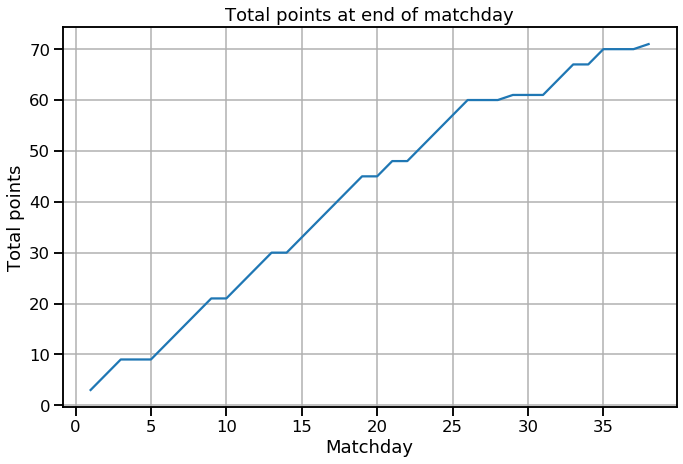

In [10]:
fig, ax = plt.subplots(figsize=(11,7))
plt.plot(df['points'].cumsum())
ax.set_title('Total points at end of matchday')
ax.set_ylabel('Total points')
ax.set_xlabel('Matchday')
ax.grid()
plt.show()

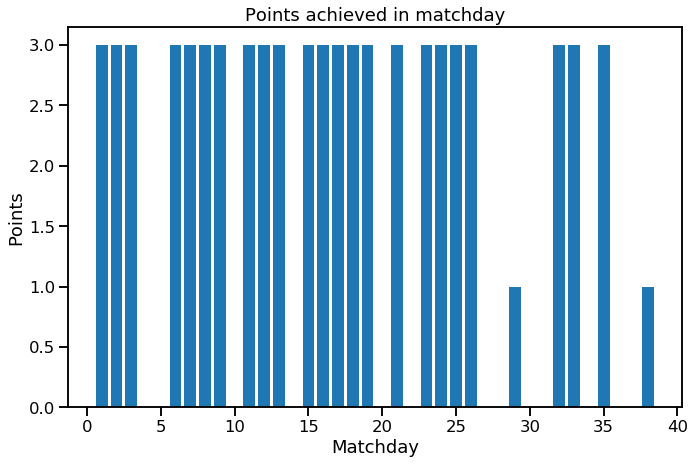

In [11]:
fig, ax = plt.subplots(figsize=(11,7))
plt.bar(df['points'].index, df['points'])
ax.set_title('Points achieved in matchday')
ax.set_ylabel('Points')
ax.set_xlabel('Matchday')
plt.show()

In [12]:
print(f"Points in 1st half of season: {df.loc[:19, 'points'].sum()}")
print(f"Points in 2nd half of season: {df.loc[20:, 'points'].sum()}")

Points in 1st half of season: 45
Points in 2nd half of season: 26


It's clear there from the statistics and the plot that THFC had a worse performance towards the end of the season.

A **change point model** may be able to identify a game in the season where form started to dip.

This is a 'small data' problem and deals with count-based data, so Bayesian modelling could help our inference.

## More context

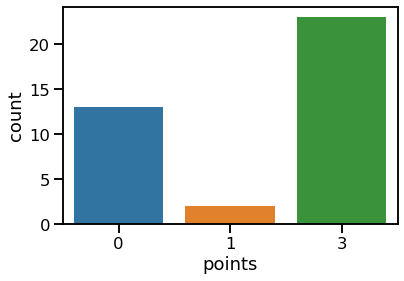

In [13]:
sns.countplot(df['points'])
plt.show()

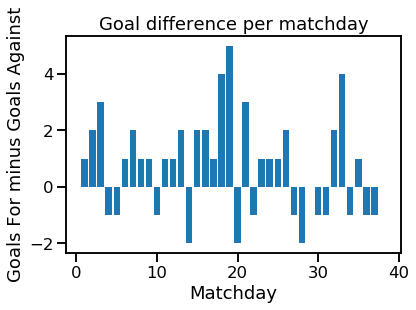

In [14]:
fig, ax = plt.subplots()
plt.bar(df.index, df['goals_for'] - df['goals_against'])
ax.set_title('Goal difference per matchday')
ax.set_ylabel('Goals For minus Goals Against')
ax.set_xlabel('Matchday')
plt.show()

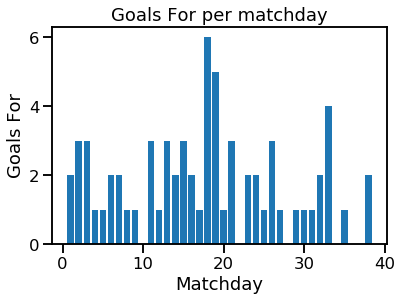

In [15]:
fig, ax = plt.subplots()
plt.bar(df.index, df['goals_for'])
ax.set_title('Goals For per matchday')
ax.set_ylabel('Goals For')
ax.set_xlabel('Matchday')
plt.show()

## Milestones

The start of a bad run seemed to happen in February.

In [16]:
df[(df['date'].dt.month == 2) | (df['date'].dt.month == 3)]

,date,opponent,home,goals_for,goals_against,points
matchday,,,,,,
25,2019-02-02,Newcastle United,1,1,0,3
26,2019-02-10,Leicester City,1,3,1,3
27,2019-02-23,Burnley,0,1,2,0
28,2019-02-27,Chelsea,0,0,2,0
29,2019-03-02,Arsenal,1,1,1,1
30,2019-03-09,Southampton,0,1,2,0
31,2019-03-31,Liverpool,0,1,2,0


The first match in the new stadium was on 2019-04-03.

The first few home matches in the new stadium were wins, but form still remained poor in April and May.

In [17]:
df[(df.date.dt.month == 4) & (df['home'])]  # first matches in new stadium

,date,opponent,home,goals_for,goals_against,points
matchday,,,,,,
32,2019-04-03,Crystal Palace,1,2,0,3
33,2019-04-13,Huddersfield Town,1,4,0,3
35,2019-04-23,Brighton & Hove Albion,1,1,0,3
36,2019-04-27,West Ham United,1,0,1,0


# Change point model

## Model setup

There have been over 20 seasons in the Premier League where there are 38 games per season.  We can utilise that information to establish prior distributions for the points per game to achieve different positions.

Info about the total points achieved by position in different seasons:
- **1st place:** Teams have won the title with as few as 75 points, as high as 100.  [Mean c. 87 points](https://www.thestatszone.com/archive/how-many-points-are-needed-for-premier-league-glory-13646).
- **4th place:** In recent years, 4th position has been achieved with as low as 60 points, but the [mean is c. 68 points](https://www.dreamteamfc.com/c/news-gossip/210144/how-many-points-do-you-need-to-get-to-into-the-premier-league-top-four/).  The highest tally was 79 points in one season.
- **10th place:** [Mean c. 50 points](https://statsbomb.com/2014/01/the-premier-league-2003-2013-points-per-league-position/), but not much variation around that compared to the higher end of the table.
- **17th place:** the rule of thumb is that 40 points is needed for safety from relegation.  Typically lose half of games and average a point per game, e.g. WDLL is 4 points from 4 games.

There are 38 games per season, so we could estimate 'points per game' for the different positions in the table.

A drop-off in points per game is a good proxy for a drop-off in performance.  We also have prior beliefs about how many points per game are expected of a team in a certain position, e.g. a team battling for safety from relegation (17th place) is expected to achieve approx. 1 point per game across the season.

The Normal distribution seems like a good starting point for modelling the distributions.  The distributions do not have an obvious skew from the data available and they appear unimodal.  However, the tails may be heavier than suggested by the Normal distribution, so something like Student's t may be more suitable.

I don't have extensive data to check the summary stats for the different positions, but let's start with some basic distributions.

Basic **point per game** distributions:
- **1st place:** e.g. $X_{01}\sim\mathcal{N}(2.3,\,0.1^{2})$  i.e. expect 88 points (standard deviation of 4 points)
- **4th place:** e.g. $X_{04}\sim\mathcal{N}(1.8,\,0.1^{2})$  i.e. expect 68 points (standard deviation of 4 points)
- **10th place:** e.g. $X_{10}\sim\mathcal{N}(1.3,\,0.05^{2})$  i.e. expect 49 points (standard deviation of 2 points)
- **17th place:** e.g. $X_{17}\sim\mathcal{N}(1.0,\,0.05^{2})$  i.e. expect 38 points (standard deviation of 2 points)

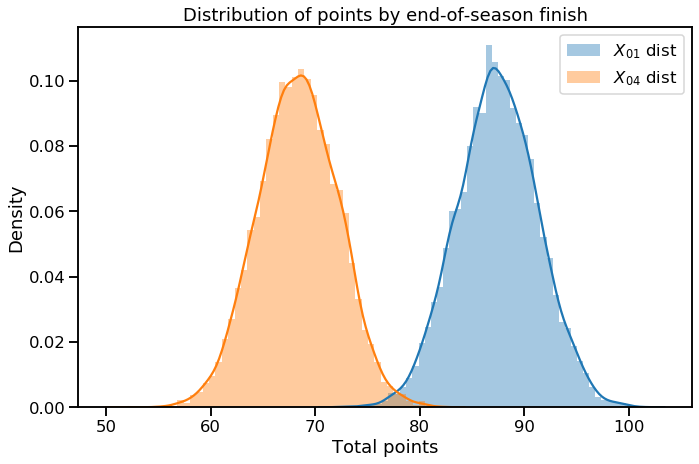

In [18]:
fig, ax = plt.subplots(figsize=(11,7))

sns.distplot(sp.stats.norm.rvs(size=10000, loc=2.3, scale=0.1) * 38, label='$X_{01}$ dist')
sns.distplot(sp.stats.norm.rvs(size=10000, loc=1.8, scale=0.1) * 38, label='$X_{04}$ dist')
ax.set_title('Distribution of points by end-of-season finish')
ax.set_ylabel('Density')
ax.set_xlabel('Total points')
ax.legend()

plt.show()

There is slight overlap, as we anticipate from the data (e.g. a team achieved 1st place with 75 points in one season, yet in another season a team achieved 4th place with 79 points).

**Now run a model using PyMC**

Specify distributions for the 'early' and 'late' points per game rates:
- `early_rate`: chose $X_{01}$, as the points per game average was well above 2 in the first half of the season.
- `late_rate`: chose $X_{17}$, as the team lost most games in the latter stages of the season.

In [19]:
with pm.Model() as ppg_model:
    # Numeric range for change point
    change_point = pm.DiscreteUniform('change_point',
                                      lower=df.index.min(),
                                      upper=df.index.max())

    # Priors of points per game for pre- and post-change
    early_rate = pm.Normal('early_rate', mu=2.3, sigma=0.1)
    late_rate = pm.Normal('late_rate', mu=1.0, sigma=0.05)

    # Specify rates for each matchday relative to change point
    rate = pm.math.switch(change_point >= df.index,
                          early_rate, late_rate)

    ppg = pm.Normal('ppg', mu=rate, observed=df['points'])

In [20]:
%%time
with ppg_model:
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [change_point]
>NUTS: [late_rate, early_rate]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:09<00:00, 4229.90draws/s]
The number of effective samples is smaller than 10% for some parameters.


CPU times: user 12.4 s, sys: 492 ms, total: 12.9 s
Wall time: 14.6 s


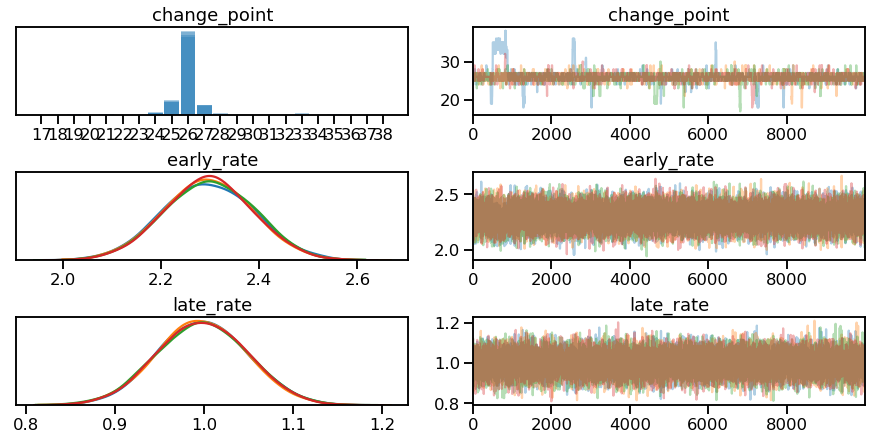

CPU times: user 5.37 s, sys: 39.7 ms, total: 5.41 s
Wall time: 3.79 s


In [21]:
%%time
pm.traceplot(trace)
plt.show()

In [22]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
change_point,25.965,1.280,24.000,27.000,0.077,0.06,277.0,232.0,1038.0,285.0,1.01
early_rate,2.297,0.091,2.130,2.471,0.001,0.00,29748.0,29748.0,29692.0,24614.0,1.00
late_rate,0.998,0.050,0.908,1.095,0.000,0.00,36007.0,35985.0,36011.0,26723.0,1.00


Plots show the MCMC algorithm has converged.

## Change point analysis

Make a bigger plot of the `change_point` and access the values directly.

In [23]:
change_point_values = (pd.Series(trace.get_values('change_point'))
                      .value_counts().sort_index())

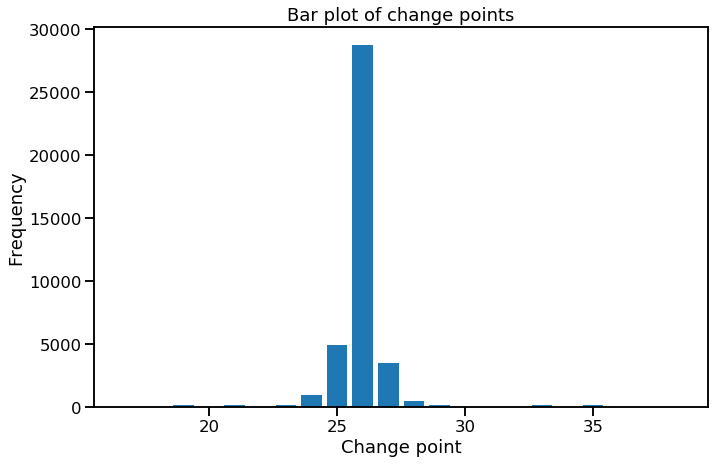

In [24]:
fig, ax = plt.subplots(figsize=(11,7))
plt.bar(change_point_values.index, change_point_values)
ax.set_title('Bar plot of change points')
ax.set_ylabel('Frequency')
ax.set_xlabel('Change point')
plt.show()

**Matchday 26** is the change point detected.

In [25]:
change_point_values.idxmax()

26

In [26]:
df.loc[change_point_values.idxmax()]

date             2019-02-10 00:00:00
opponent              Leicester City
home                               1
goals_for                          3
goals_against                      1
points                             3
Name: 26, dtype: object

A win against Leicester City.

Performance became worse after that match.

In [27]:
df.loc[change_point_values.idxmax() + 1]

date             2019-02-23 00:00:00
opponent                     Burnley
home                               0
goals_for                          1
goals_against                      2
points                             0
Name: 27, dtype: object

In [28]:
print(f"PPG up to MD{change_point_values.idxmax()} (inclusive): {df.loc[:change_point_values.idxmax(), 'points'].sum() / len(df.loc[:change_point_values.idxmax()]):.3f}")
print(f"PPG from MD{change_point_values.idxmax()+1} onwards: {df.loc[change_point_values.idxmax()+1:, 'points'].sum() / len(df.loc[change_point_values.idxmax()+1:]):.3f}")

PPG up to MD26 (inclusive): 2.308
PPG from MD27 onwards: 0.917


Here are snippets of a [matchday report](https://metro.co.uk/2019/02/23/tottenhams-title-bid-ends-begins-burnley-pull-off-upset-8722489/) for MD27:
- "Tottenham Hotspur blew the chance to move within two points of the Premier League summit after suffering a 2-1 defeat to Burnley on Saturday afternoon."
- "The title has long seemed a two-horse race, but Spurs had the opportunity to put themselves right back in contention..."